In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import os

In [3]:
df=pd.read_csv("train.csv")

In [4]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [5]:
df.shape

(54808, 14)

In [6]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [7]:
df["department"].value_counts()

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

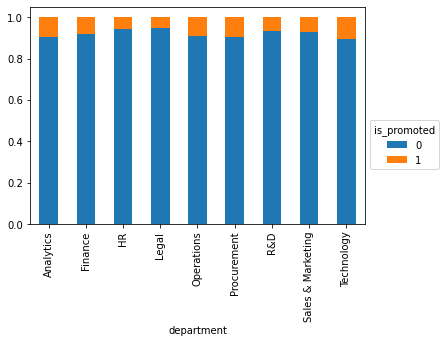

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
ct = pd.crosstab(df.department,df.is_promoted,normalize='index')
ct.plot.bar(stacked=True)
plt.legend(title='is_promoted',bbox_to_anchor=(1,0.5))
plt.show()

While Technology department had highest percentage of employees getting promoted, Legal department has the least number. But we don't see major differences in terms of percentages

### Percentage of promotions across all the regions

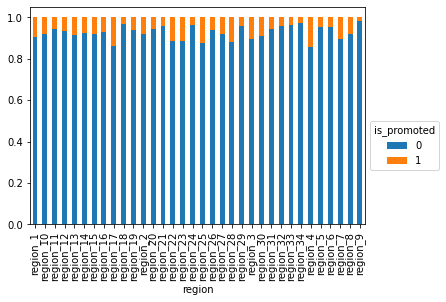

In [9]:
reg = pd.crosstab(df.region,df.is_promoted,normalize='index')
reg.plot.bar(stacked=True)
plt.legend(title='is_promoted',bbox_to_anchor=(1,0.5))
plt.show()

### Distribution of promotions among people with different Educational backgrounds

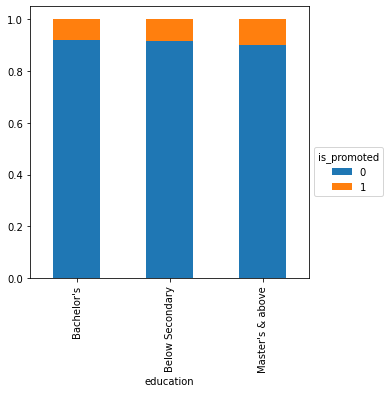

In [10]:
plt.rcParams['figure.figsize'] = [5, 5]
edu = pd.crosstab(df.education,df.is_promoted,normalize='index')
edu.plot.bar(stacked=True)
plt.rcParams['figure.figsize'] = [5, 5]
plt.legend(title='is_promoted',bbox_to_anchor=(1,0.5))
plt.show()

we can see the percentages are pretty much the same aross different educational backgrounds.

### Variation of promotion percentage with respect to gender

In [11]:
pd.crosstab(df.gender,df.is_promoted,normalize='index')

is_promoted,0,1
gender,,
f,0.910066,0.089934
m,0.916849,0.083151


There is major differnce in percentages across genders too. Let us check if differnce arises within the departments

### Variation of promotion percentage with recruitment channel that they have come from

In [12]:
pd.crosstab(df.recruitment_channel,df.is_promoted,normalize='index')

is_promoted,0,1
recruitment_channel,,
other,0.916048,0.083952
referred,0.879159,0.120841
sourcing,0.914987,0.085013


According to the data, percentage of promotions is higher among the employees who got recruited through referrals.

### Variation of promotion percentage with respect to KPIs met or not

In [13]:
pd.crosstab(df['KPIs_met >80%'],df.is_promoted,normalize='index')

is_promoted,0,1
KPIs_met >80%,,
0,0.960413,0.039587
1,0.830906,0.169094


In [14]:
sales = df[df['department']=='Sales & Marketing']
operations = df[df['department']=='Operations']
technology = df[df['department']=='Technology']
hr = df[df['department']=='HR']
fin = df[df['department']=='Finance']
legal = df[df['department']=='Legal']
RnD = df[df['department']=='R&D']
pd.crosstab(sales.gender,sales.is_promoted,normalize='index')

is_promoted,0,1
gender,,
f,0.944198,0.055802
m,0.924229,0.075771


In [15]:
pd.crosstab(operations.gender,operations.is_promoted,normalize='index')

is_promoted,0,1
gender,,
f,0.905495,0.094505
m,0.912907,0.087093


In [16]:
pd.crosstab(technology.gender,technology.is_promoted,normalize='index')

is_promoted,0,1
gender,,
f,0.900646,0.099354
m,0.887126,0.112874


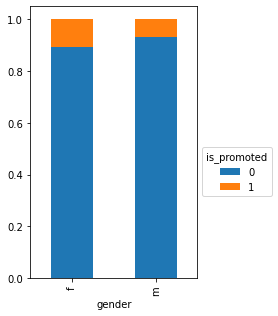

In [17]:
plt.rcParams['figure.figsize'] = [3, 5]
gender = pd.crosstab(RnD.gender,RnD.is_promoted,normalize='index')
gender.plot.bar(stacked=True)
plt.legend(title='is_promoted',loc='upper left',bbox_to_anchor=(1, 0.5))
plt.show()

Slight difference in the ratios can be seen within the departments unlike the ratios calculated without any department barriers.

### Difference in the percentage of promoted employees with respect to previous year ratings

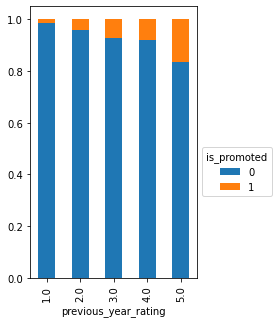

In [18]:
rating = pd.crosstab(df.previous_year_rating,df.is_promoted,normalize='index')
rating.plot.bar(stacked=True)
plt.legend(title='is_promoted',loc='upper left',bbox_to_anchor=(1, 0.5))
plt.show()

The ratio of promoted employees increases with previous year rating which is quite obvious.

### Distribution of average training score

In [19]:
bins = [30,40,50,60,70,80,90,100]
labels = ['30-40','40-50','50-60','60-70','70-80','80-90','90-100']
df['score_binned'] = pd.cut(df['avg_training_score'], bins=bins, labels=labels)
df['score_binned'].value_counts()

50-60     16020
40-50     11996
60-70      9973
80-90      8739
70-80      7494
90-100      579
30-40         7
Name: score_binned, dtype: int64

While most of the employees have score in the range of 50-60, the least score bin has very faint number,

### Distribution of promoted employees ratio across different score ranges

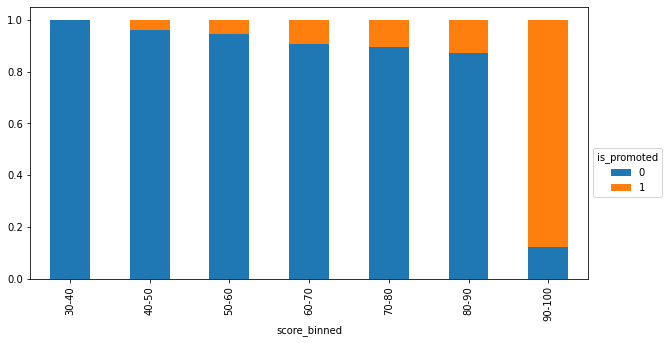

In [20]:
plt.rcParams['figure.figsize'] = [10, 5]
score_bin = pd.crosstab(df.score_binned,df.is_promoted,normalize='index')
score_bin.plot.bar(stacked=True)
plt.legend(title='is_promoted',loc='upper left',bbox_to_anchor=(1, 0.5))
plt.show()

Promotions ratio increases with the score and the ratio is very high in 90-100 range which means getting promoted is highly dependent on the average score.

### Distribution of promotion ratios with respect to age

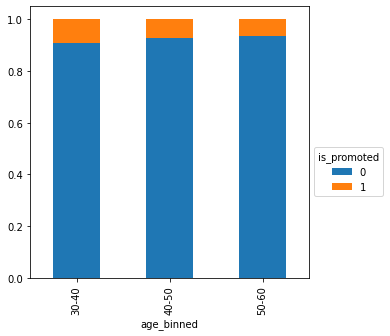

In [21]:
plt.rcParams['figure.figsize'] = [5, 5]
age_bins = [20,30,40,50,60]
age_labels = ['20-30','30-40','40-50','50-60']
df['age_binned'] = pd.cut(df['age'], bins=bins, labels=labels)
df['age_binned'].value_counts()
age_bin = pd.crosstab(df.age_binned,df.is_promoted,normalize='index')
age_bin.plot.bar(stacked=True)
plt.rcParams['figure.figsize'] = [5, 5]
plt.legend(title='is_promoted',loc='upper left',bbox_to_anchor=(1, 0.5))
plt.show()

Ratio doesn't vary much with age.

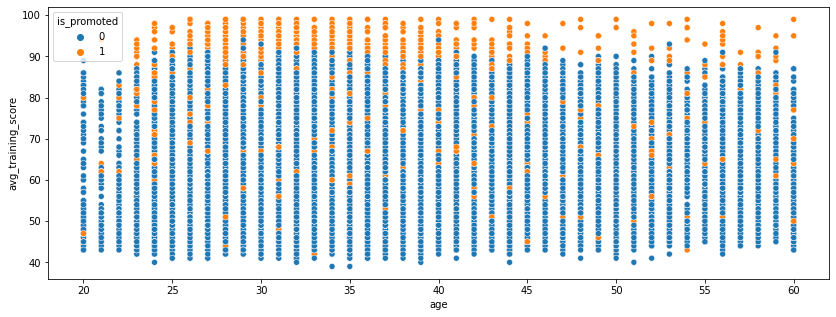

In [22]:
plt.rcParams['figure.figsize'] = [14, 5]
sns.scatterplot(x='age',y='avg_training_score',hue='is_promoted',data=df)
plt.show()

This graph reinforces the fact the promotions are majorly dependent on the score and not on age.

### Mean score of employees with different educational background

In [23]:
df.groupby(["education"])['avg_training_score'].mean()

education
Bachelor's          63.422046
Below Secondary     64.925466
Master's & above    64.061240
Name: avg_training_score, dtype: float64

Mean training score doesn't vary with education

### Fill missing values of 'previous_year_rating' with mean based on 'KPIs_met >80%' and 'education' with median based on 'department'

In [24]:
df['previous_year_rating'] = df.groupby(["KPIs_met >80%"])["previous_year_rating"].apply(lambda x: x.fillna(x.mean()))
df["education"] = df["education"].astype('object')
df['education'] = df.groupby(["department"])["education"].apply(lambda x: x.fillna(x.value_counts().index[0]))

### Filling the missing values

In [25]:
df.isnull().any()

employee_id             False
department              False
region                  False
education               False
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating    False
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
is_promoted             False
score_binned            False
age_binned               True
dtype: bool

In [26]:
scaled_features = df.copy()
col_names = ['no_of_trainings', 'age','previous_year_rating','length_of_service','awards_won?','avg_training_score']
label_names = ['department','gender','recruitment_channel','region']
features = scaled_features[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.get_dummies(scaled_features, columns=label_names, drop_first=True)
scaled_features[col_names] = features
scaled_features.drop(columns=['employee_id','age','education','score_binned','age_binned'],inplace=True)

The transformed features are fit to a Gradient Boosting Classifier

# XGBClassifier

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
scaled_features.loc[:, scaled_features.columns != 'is_promoted'], scaled_features['is_promoted'], test_size=0.33, random_state=42)

In [28]:
#Hyper parameter optimization
params={
    "learning_rate"    : [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth"        : [3,4,5,6,8,10,12,15],
    "min_child_weight" : [1,3,5,7],
    "gamma"            : [0.0,0.1,0,.2,0.3,0.4],
    "colsample_bytree" : [0.3,0.4,0.5,0.7],
}

In [29]:
classifier=XGBClassifier()

Comparing & searching which parameters are the best-fitted for our model to give good accuracy

In [30]:
random_search=RandomizedSearchCV(classifier,param_distributions=params)

In [31]:
#fitting the model
random_search.fit(X_train,y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]})

In [32]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Here the random_search selects the best estimators required for the xgbclassifier

In [33]:
random_search.best_params_

{'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.3,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

### Making our classifier on the basis of best parameters given by random search

In [34]:
classifier=XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
              missing=None, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1,scale_pos_weight=1,seed=None,silent=True,subsample=1)

In [35]:
preds=random_search.predict(X_test)

In [36]:
accuracy = metrics.accuracy_score(y_test,preds)
'accuracy - '+str(accuracy)

'accuracy - 0.9449328246807099'

In [37]:
f1 = metrics.f1_score(y_test, preds)
'f1 score - '+str(f1)


'f1 score - 0.513671875'

In [38]:
recall = metrics.recall_score(y_test,preds)
'recall - '+str(recall)

'recall - 0.3568521031207598'

In [39]:
precision = metrics.precision_score(y_test,preds)
'precision - '+str(precision)

'precision - 0.9163763066202091'

In [40]:
cm=confusion_matrix(y_test,preds)
cm

array([[16565,    48],
       [  948,   526]], dtype=int64)

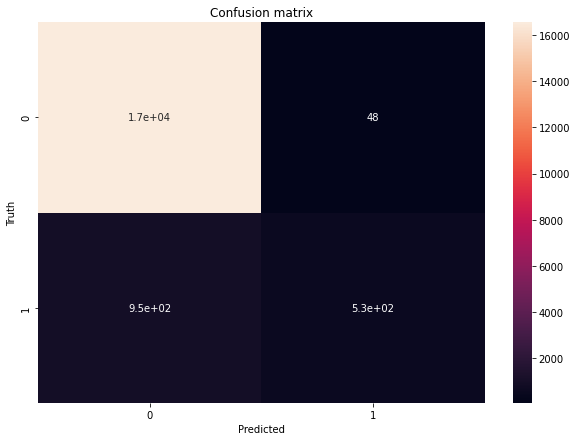

In [41]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion matrix")
plt.show()

# Decision tree classifier...

In [43]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1

C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1

C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1

C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1

C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1024),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=True)

In [44]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=8,
                       max_features='log2', random_state=1024)

In [47]:
tree = DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='entropy',
            max_depth=8, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0,
            random_state=1024, splitter='best')
tree.fit(X_train, y_train)
y_predict = tree.predict(X_test)

In [48]:
accuracy = metrics.accuracy_score(y_test,y_predict)
'accuracy - '+str(accuracy)

'accuracy - 0.9272405595178858'

In [49]:
f1 = metrics.f1_score(y_test, y_predict)
'f1 score - '+str(f1)

'f1 score - 0.20338983050847456'

In [50]:
recall = metrics.recall_score(y_test,y_predict)
'recall - '+str(recall)

'recall - 0.11397557666214382'

In [51]:
precision = metrics.precision_score(y_test,y_predict)
'precision - '+str(precision)

'precision - 0.9438202247191011'

In [52]:
cm=confusion_matrix(y_test,y_predict)
cm

array([[16603,    10],
       [ 1306,   168]], dtype=int64)

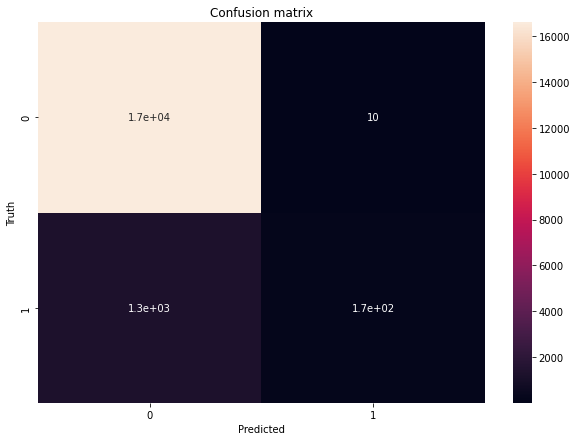

In [53]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion matrix")
plt.show()

# Random forest classifier

In [54]:
rfc=RandomForestClassifier(n_jobs=-1, random_state=0,class_weight='balanced',n_estimators=100,bootstrap=True, max_depth=80)

In [55]:
param_grid = { 
    'n_estimators': [200, 500,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [56]:
model = GridSearchCV(estimator = rfc, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)

In [57]:
model.fit(X_train,y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=80, n_jobs=-1,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 800]},
             verbose=2)

In [58]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 800}

In [59]:
final_rfc=RandomForestClassifier(random_state=0, max_features='log2', n_estimators= 800, max_depth=8, criterion='gini')

In [61]:
final_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=800,
                       random_state=0)

In [62]:
preds=final_rfc.predict(X_test)

In [63]:
accuracy = metrics.accuracy_score(y_test,preds)
'accuracy - '+str(accuracy)

'accuracy - 0.9263559462597446'

In [64]:
f1 = metrics.f1_score(y_test, preds)
'f1 score - '+str(f1)

'f1 score - 0.17879161528976573'

In [65]:
recall = metrics.recall_score(y_test,preds)
'recall - '+str(recall)

'recall - 0.09837177747625508'

In [66]:
precision = metrics.precision_score(y_test,preds)
'precision - '+str(precision)

'precision - 0.9797297297297297'

In [67]:
cm=confusion_matrix(y_test,preds)
cm

array([[16610,     3],
       [ 1329,   145]], dtype=int64)

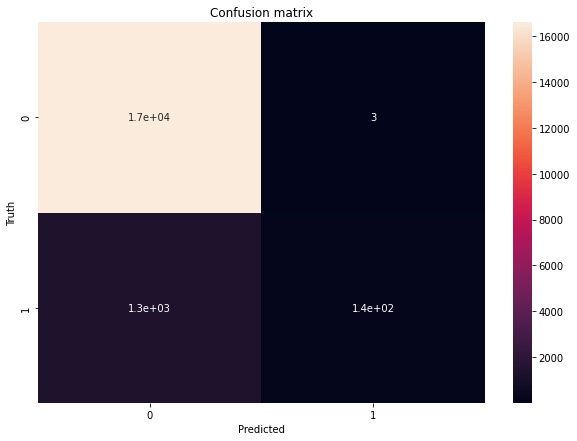

In [68]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion matrix")
plt.show()

# Hence Decision tree algo gives much accurate result as compared to random forest and gradient boosting algorithms